<a href="https://colab.research.google.com/github/giomorakis/finance_python/blob/main/binance_level2data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Market Micro-Structure of the Criptocurrency Excahge: 
## Visualizing the Order Book with the Binance API in Python

Exploring the live order book data on Binance through its official API using Python (main code for interacting with the API comes from the article by [Louis Tiao](https://tiao.io/post/exploring-the-binance-cryptocurrency-exchange-api-orderbook/)). Here we directly interact with the API endpoints and explicitly make the low-level HTTP requests ourselves. We will be making the requests using the requests library. Thereafter, we will process the results with **pandas**, and visualize them with **matplotlib** and **seaborn**.

The limit order book is a record of unexecuted orders to buy (or sell) a given quantity of stock at or below (above) a specified price. The orders on the bid and ask side represent willingness to buy and to sell, respectively, where the former are arranged from highest (best price) to lowest and latter, from the lowest (best price) to highest. 

First step is to import the necessary Dependencies:

In [18]:
# Import Dependencies
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import data_table


We make the GET request for the symbol ```ETHBUSD``` from the ```/depth``` endpoint and record the time of the request:



In [19]:
# To make a GET request for the symbol ETHBUSD from the /depth endpoint:
r = requests.get("https://api.binance.com/api/v3/depth",
                 params=dict(symbol="ETHBUSD"))
now = datetime.now()
results = r.json()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

Then procceed to load the buy and sell orders, indicated as _bids_ and _asks_ respectively, into a DataFrame:

In [20]:
# Load the buy and sell orders, or bids and asks, into respective DataFrames:

frames = {side: pd.DataFrame(data=results[side], columns=["price", "quantity"],
                             dtype=float)
          for side in ["bids", "asks"]}

Concatenate the DataFrames containing bids and asks into one big frame:

In [21]:
# Concatenate the DataFrames containing bids and asks into one big frame:

frames_list = [frames[side].assign(side=side) for side in frames]
data = pd.concat(frames_list, axis="index", 
                 ignore_index=True, sort=True)
data["date"] = now

In order to have a first glance of the database we get a statistical summary of the price levels in the bids and asks:

In [22]:
# Get a statistical summary of the price levels in the bids and asks:

price_summary = data.groupby("side").price.describe()
price_summary

,count,mean,std,min,25%,50%,75%,max
side,,,,,,,,
asks,100.0,2690.4429,1.731451,2687.14,2688.8850,2690.655,2691.8525,2693.34
bids,100.0,2684.0473,1.513919,2681.89,2682.7025,2683.775,2685.3225,2687.13


It is worth noticing that the Binance API can only provide the top 100 entries in the order book. Since the order book is sorted by best prices, this indicates that we obtain the lowest 100 asks and the highest 100 bids entries. We can check this by looking at the ```count``` column.

In [23]:
# Observe the Structure of the Order Book

#data_table.DataTable( data, num_rows_per_page=10)
bid_side = data.iloc[:,[0,1]][data['side'] == 'bids'].rename(columns = {'price':'price_bid', 'quantity':'quantity_bid'})
bid_side = bid_side.sort_index(axis = 1, ascending=False)
ask_side = data.iloc[:,[0,1]][data['side'] == 'asks'].rename(columns = {'price':'price_ask', 'quantity':'quantity_ask'}).reset_index(drop=True)
order_book = pd.concat([bid_side, ask_side], axis= 1)
data_table.DataTable(order_book, num_rows_per_page=10, min_width= '700px')

,quantity_bid,price_bid,price_ask,quantity_ask
0,25.69968,2687.13,2687.14,0.01600
1,0.51932,2686.85,2687.53,1.11643
2,2.37207,2686.84,2687.54,0.40000
3,1.11643,2686.83,2687.66,0.30606
4,2.79073,2686.79,2687.67,0.58298
...,...,...,...,...
95,0.70473,2682.00,2693.06,0.05550
96,1.00000,2681.98,2693.26,3.82519
97,0.07000,2681.92,2693.28,4.00000
98,0.20000,2681.91,2693.31,2.00000


### Top of the Order Book

With the structure of the order book in descending bid prices and ascending ask prices, the prices of the most recent trades will be somewhere between the maximum bid price and the minimum asking price. This first section is known as the _top of the order book_. In here, it is often indicated the difference between these two price leves which is known as the _bid-ask spread_, that also measures the market efficiency.

In [24]:
# Best Bid & Ask Prices

frames["bids"].price.max()
frames["asks"].price.min()

2687.14

We can also get this information from the ```/ticker/bookTicker``` endpoint:

In [25]:
r = requests.get("https://api.binance.com/api/v3/ticker/bookTicker", params=dict(symbol="ETHBUSD"))
book_top = r.json()


We proceed to read this into a Pandas Series and render as a Markdown table:

In [26]:
name = book_top.pop("symbol")  # get symbol and also delete at the same time
s = pd.Series(book_top, name=name, dtype=float)

pd.DataFrame(s)



,ETHBUSD
bidPrice,2687.13000
bidQty,21.69968
askPrice,2687.14000
askQty,0.68800


### Visualize the Order Book with a Scatter Plot

To better understand the structure of the order book, we can visualize all its entries using a scatter plot. Where prices are indicated along the x-axis and quantities in along the y-axis. In the presented code, the _hue_ argument indicates how to group the variables, whether the entry is an _ask_ or a _bid_.

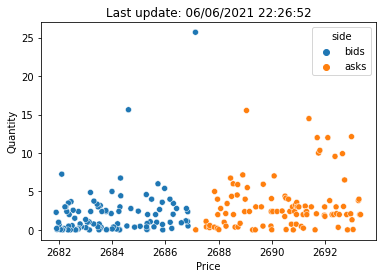

In [27]:
# Scatter plot: Order Book

fig, ax = plt.subplots()

ax.set_title(f"Last update: {dt_string}")

sns.scatterplot(x="price", y="quantity", hue="side", data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

This is the most verbose visualization, displaying all the raw information, but perhaps also providing the least amount of actionable insights.

### Histogram of the Order Book

The information can be compress into a histogram plot to have a better sense of the overall data.

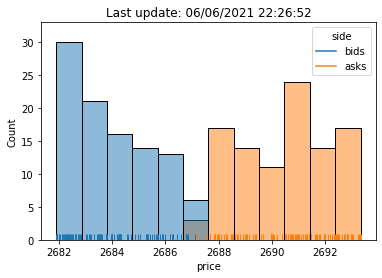

In [28]:
# Histogram plot

fig, ax = plt.subplots()

ax.set_title(f"Last update: {dt_string}")

sns.histplot(x="price", hue="side", bins= 12,  data=data, ax=ax)
sns.rugplot(x="price", hue="side", data=data, ax=ax)

plt.show()

While this allow us to visualize the number and concentrancion of the bid and asks it only counts the entries for each price under the specific _side_ of the market. It lacks the ability to take into consideration the volume of such entry. This creates a misleading picture since entries are categorized as equal. One entry at $p_1$ and one entry at $p_2$ are counted the same, no matter if the first entry was for 100 ETH and the secon at 4.

### Weighted Histogram Plot

A solution to the misleading picture of the overall histogram is to incorporate the quantities as weights to the histogram. This can simply be done by icluding the argument _weights_  as ```weights = "quantity"```, as follows:

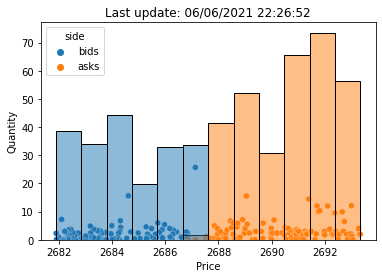

In [29]:
# Weighted histogram plot

fig, ax = plt.subplots()

ax.set_title(f"Last update: {dt_string}")

sns.histplot(x="price", weights="quantity", hue="side", bins= 12, data=data, ax=ax)
sns.scatterplot(x="price", y="quantity", hue="side", data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

With this modification a more accurate picture about demand ad supply can be observed. Nevertheless, it still offers limited actionable insights.

A limitation lies in the question of what is the minimun price that would you need to bid so that you secure that your bid at quantity $x$ is guaranteed to be filled. To obtain this information, you need to take the cumulative sum of the _quantity_ with the associated prices in _ascending_ order. 

Conversely, if you wanted to work out at what price you should be asking for so that your sale is guaranteed to be filled, you need to do the same, but with the prices in _descending_ order.

### Depth Chart: Weighted empirical CDF (ECDF) plot

The depth chart is essentially just a combination of two empirical cumulative distribution function or ECDF plots. With this transformation we can solve for the limitation of the previous plot.

More precisely, these distributions are weighted and unnormalized ECDF plots. As before, they are weighted by the quantity and are unnormalized in the sense that they are not proportions between. Rather, they are simply kept as counts. Additionally, in the case of bids, we take the complementary ECDF (which basically reverses the order in which the cumulative sum is taken).

In code, this amounts to making calls to ```sns.ecdfplot``` with the options ```weights="quantity"``` and ```stat="count"``` (to keep the plot unnormalized)8. Finally, for the bids, we add the option ```complementary=True```. Putting it all together:

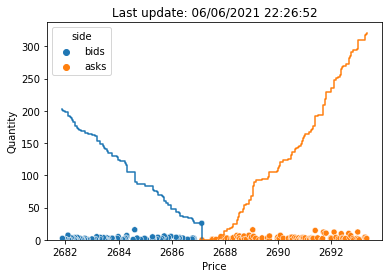

In [30]:
# Weighted empirical CDF (ECDF) plot – aka the “Depth Chart”

fig, ax = plt.subplots()

ax.set_title(f"Last update: {dt_string}")

sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=frames["bids"], ax=ax)
sns.ecdfplot(x="price", weights="quantity", stat="count", data=frames["asks"], ax=ax)
sns.scatterplot(x="price", y="quantity", hue="side", data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

With this chart we can walk along the respective curves and understand at wich price our buy or sell would be satisfied by the matching engine at an instant. If we want to sell $x$ quantity of the asset we look at the vertical axis and find the point in the bid curve to find the necesary price level. For a case of buying $x$ quantity the same process applies but by loking at the ask curve.

### Notional Volume Weighted Average Price

An adequate methodologies to analyse and extract limit order book information content and the adequate use of this information for optimal trading strategies design is the proposed a measure of market impact that consists on the Volume Weighted Average Price (VWAP) over a trading day. In order words, for the same time $t$ we have that: 

$ NVWAP_i=\frac {\sum_{j=0}^{i} P_j \times Vol_j}{\sum_{j=0}^{i} Vol_j}$

Where $P_j$ and $Vol_j$ are the price and volume for entry $j$ in the order book. Which is done independently for the Bid side and the Ask side. 

Based on this measure we can have a quantitative framework to measure the change in the shape of empirical liquidity supply and demand curve of the market.


To better understand the transformation we can plot these new measures. We first realize the necesary transformations.

In [31]:
# Create the Notional Volume Weighted Average Price (NVWAP)

cumVol_bid = np.cumsum(data[data['side'] == 'bids']['quantity'])
cumVal_bid = np.cumsum(data[data['side'] == 'bids']['price'].multiply(data[data['side'] == 'bids']['quantity']))
nvwap_bid = cumVal_bid.divide(cumVol_bid)
cumVol_ask = np.cumsum(data[data['side'] == 'asks']['quantity'])
cumVal_ask = np.cumsum(data[data['side'] == 'asks']['price'].multiply(data[data['side'] == 'asks']['quantity']))
nvwap_ask = cumVal_ask.divide(cumVol_ask)


Then we proceed to graph the NVWAP curves for the bid and ask sides of the market.

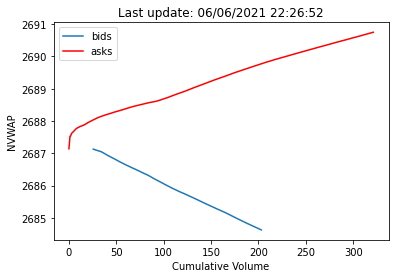

In [32]:
# Plot the NVWAP

plt.plot(cumVol_bid, nvwap_bid)
plt.plot(cumVol_ask, nvwap_ask, color = 'red')
plt.xlabel("Cumulative Volume")
plt.ylabel("NVWAP")
plt.legend(['bids', 'asks'])
plt.title(f"Last update: {dt_string}")
plt.show()

With this transformation we can observe how the slope and size of the cuvrve chances and thus, allows to understand whether the market forces will indicate a rise or fall in the price. Esencially, we are looking at a truncated Demand and Supply curve, which are shown at the availabe unit after the point where both curves cut, the _mid-price_.

Both the _Depth Chart_ and the _NVWAP Curves_ are complementary tools to better understand any financial market. They allow to gain more in depth insights and improve the decision making process. It would be usefull to further explore the derived insights by looking at machine learning techinques that can capitilize on this information and better predict price movements and the shape of the market in the near future.